### Import necessary libraries and download the dataset

In this code cell, we import the required libraries.

We'll use Datalab from cleanlab to perform the data issue checks. We'll use numpy to load precomputed features and predicted probabilities for our dataset.
We'll use the datasets library to load our data into Datalab. We'll use matplotlib to visualize our results. 

We then download the caltech256-subset dataset, the features and predicted probabilities and extract them into the data directory.

In [1]:
from cleanlab import Datalab

import matplotlib.pyplot as plt 
import numpy as np
import datasets

### Load dataset

We'll fetch a subset of the Caltech-256 dataset. We'll use `wget` to download the dataset from the web, and then we'll use `tar` to extract the files.

In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datalab/caltech256-subset.tar.gz'
!mkdir -p data
!tar -xf caltech256-subset.tar.gz -C data/

File ‘caltech256-subset.tar.gz’ already there; not retrieving.



We load the dataset using the Hugging Face datasets library with the "imagefolder" loader into a `Dataset` object
The dataset is stored in the ./data/caltech256-subset directory.

In [3]:
dataset_hf = datasets.load_dataset("imagefolder", data_dir="./data/caltech256-subset", split="train")

Resolving data files:   0%|          | 0/635 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/vscode/.cache/huggingface/datasets/imagefolder/default-91edeb49c3fce395/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


# Load pre-computed features and predicted probabilities

Here, we load the pre-computed features and predicted probabilities for the images in the dataset. 

The predicted probabilities were obtained from a fine-tuned Swin Transformer model with 5-folds cross-validation, 
and the features were generated using the same model trained on the first 4 folds of the dataset.

In [ ]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datalab/pred_probs_and_features.tar.gz'
!tar -xf caltech256-subset.tar.gz -C data/

In [4]:
features = np.load("data/features.npy")
pred_probs = np.load("data/pred_probs.npy")

### Initialize Datalab and find issues in the dataset

We create a Datalab object with the dataset and the name of the label column.

We then use the find_issues method to audit the quality of the dataset using the provided features and predicted probabilities.

Then, we generate a report of the identified issues.

In [5]:
lab = Datalab(data=dataset_hf, label_name="label")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Audit complete. 51 issues found in the dataset.


In [6]:
lab.report(include_description=False)

Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
       outlier 0.735523          26
near_duplicate 0.244542          14
         label 0.982677          11

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


---------------------- outlier issues ----------------------

Number of examples with this issue: 26
Overall dataset quality in terms of this issue: : 0.7355

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score  nearest_neighbor  distance_to_nearest_neighbor
398              True       0.412073               257                      0.848089
397              True       0.420990               149                      0.845467
633              True       0.425188               396                      0.846003
241              True       0.427850               119                      0.817756
396              True       0.431380               

### Get the different issue types

Here, we retrieve the different types of issues found in the dataset (label, outlier, and near_duplicate) by calling the get_issues method of the Datalab object.

This allows us to concentrate on one type of issue at a time if we want to.


In [7]:
label_issues, outlier_issues, near_duplicate_issues = (
    lab.get_issues(name) 
    for name in ["label", "outlier", "near_duplicate"]
)

We define a function, `make_image_plot` that we use to visualize the images in the dataset and provide some context to images that might have issues.

In [8]:
def make_image_plot(ax,img, label=None, additonal_info=None):
    title = ""
    if label is not None:
        title = 'Label {}'.format(label)

    if additonal_info is not None:
        title += '\n' + additonal_info

    if title:
       ax.set_title(title)
    ax.axis("off")
    ax.imshow(img, cmap="gray")


## Visualizing issues

The remainder of this notebook is dedicated to visualizing the different types of issues found in the dataset.

Generally, this involves:

1. Querying one of the `issues` dataframes to find examples that are considered to have an issue or not.

2. Sorting the filtered results by their associated quality scores in ascending order.

3. Iterating over the sorted results and creating subplots of the images with any relevant information or context.

### Some examples that are *not* considered to have near duplicates

While the near duplicate issue can be understood intuitively and many clear issues are found in the dataset, some interesting examples of images can be found that are just above the threshold for being considered a near duplicate.

Here, we show images with low near duplicate quality scores and their nearest neighbors.
Ideally, these images should be similar but not indistinguishable from their nearest neighbors. 

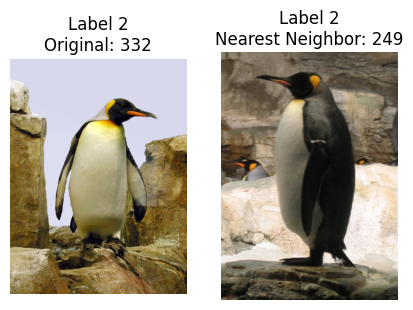

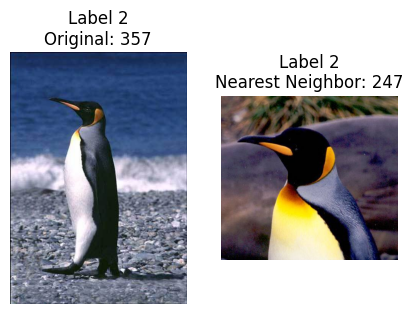

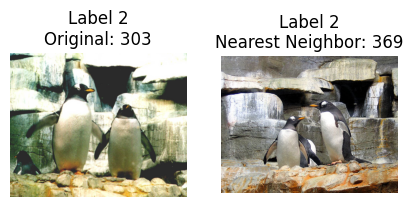

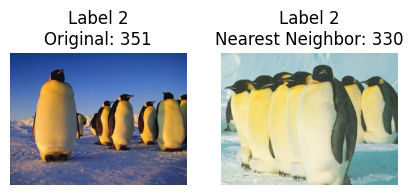

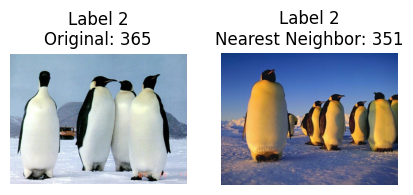

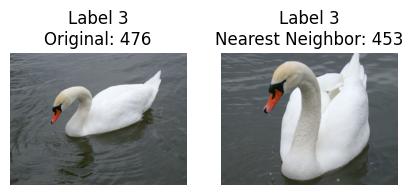

In [9]:
# Collect the indices of the images that are near duplicates
ids = (
    near_duplicate_issues
    .query("not is_near_duplicate_issue")
    .sort_values("near_duplicate_score", ascending=True)
    .head(10)
    .index
    .tolist()
)

nearest_neighbors = outlier_issues["nearest_neighbor"].tolist()

# Skip images that have already been displayed (both the original and the nearest neighbor)
seen_ids = set()
for idx in ids:
    if idx in seen_ids:
        continue
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    image = dataset_hf[idx]["image"]
    nn_idx = nearest_neighbors[idx]
    make_image_plot(ax[0], image, dataset_hf[idx]["label"], additonal_info=f"Original: {idx}")
    nearest_neighbor_eg = dataset_hf[nn_idx]
    make_image_plot(ax[1], nearest_neighbor_eg["image"], nearest_neighbor_eg["label"], additonal_info=f"Nearest Neighbor: {nn_idx}")
    plt.show()
    seen_ids.add(nn_idx)

## Some examples that are considered to have near duplicates

In this section, we display examples from the dataset that are considered to have near duplicates. We achieve this by:

Defining a `plot_near_duplicate_images` function that takes a row from the `near_duplicate_issues` DataFrame as input. This function:

1. Retrieves the original image and its given label based on the row index.

2. Creates a subplot for the original image and each of its near duplicates.


We'll query the `near_duplicate_issues` DataFrame to find examples that are considered to have near duplicates, sort them, then apply the function to each of them.

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts.

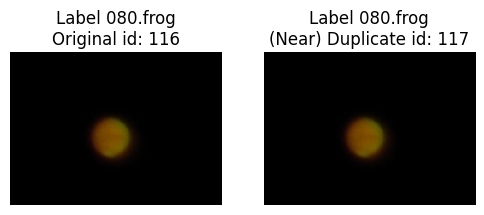

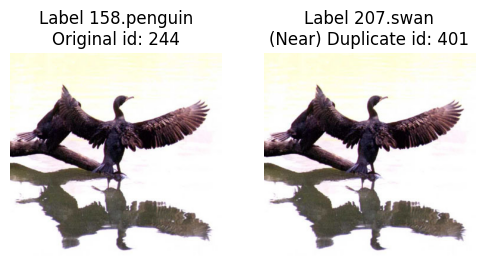

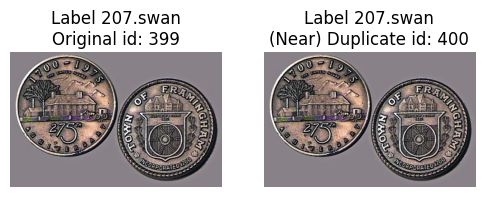

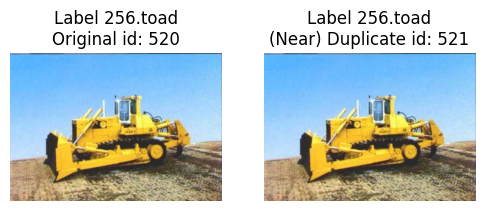

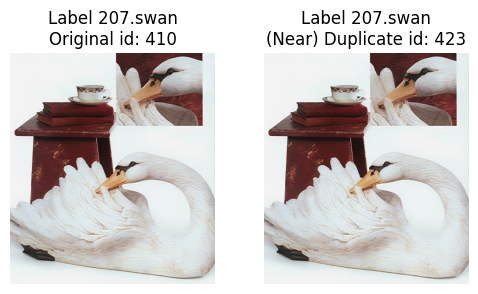

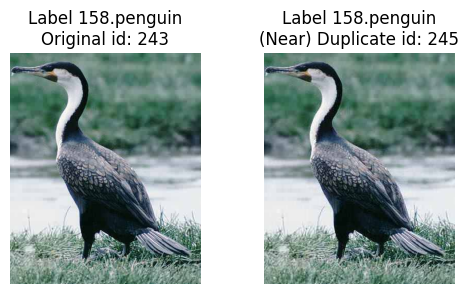

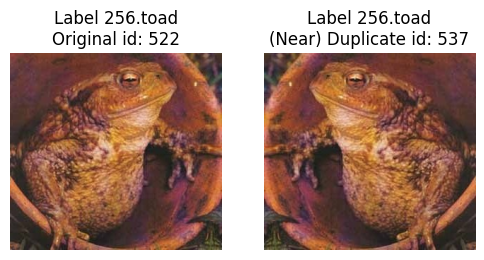

In [10]:
seen_ids = set()

def plot_near_duplicate_images(row):
    def get_image_and_given_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        return image, label

    img1_idx = row.name
    if img1_idx in seen_ids:
        return

    duplicate_images = row.near_duplicate_sets

    num_figures = len(duplicate_images) + 1
    _, ax = plt.subplots(1, num_figures, figsize=(num_figures * 3, 3))
    original_image, label = get_image_and_given_label(img1_idx)
    make_image_plot(ax[0], original_image, label, additonal_info=f"Original id: {img1_idx}")

    seen_ids.add(img1_idx)
    
    for i, duplicate_image in enumerate(duplicate_images):
        img2_idx = int(duplicate_image)
        if True:
            img2, label2 = get_image_and_given_label(img2_idx)
            make_image_plot(ax[i + 1], img2, label2, additonal_info=f"(Near) Duplicate id: {img2_idx}")
            seen_ids.add(img2_idx)

(
    near_duplicate_issues
    .query("is_near_duplicate_issue")
    .sort_values("near_duplicate_score", ascending=True)
    .apply(plot_near_duplicate_images, axis=1)
)
plt.show()

# Visualizing examples with label errors


In this section, we focus on visualizing examples in the dataset that have label errors. Label errors occur when the given label for an image is incorrect, usually due to mislabeling during dataset creation. Some of these examples are available at [labelerrors.com](https://labelerrors.com) under the Caltech-256 dataset.

We define a `plot_label_issues` function to visualize the examples with label errors. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

    - Additionally, we fetch the file name of the image to use as the title of the plot when necessary.

2.  Creates a plot for the image using the `make_image_plot` function with the given label and additional information about the predicted label.



We filter the `label_issues` DataFrame to find examples that are considered to have label errors.

Then, we sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

Finally, we apply the `plot_label_issues` function to each row of the filtered and sorted results.

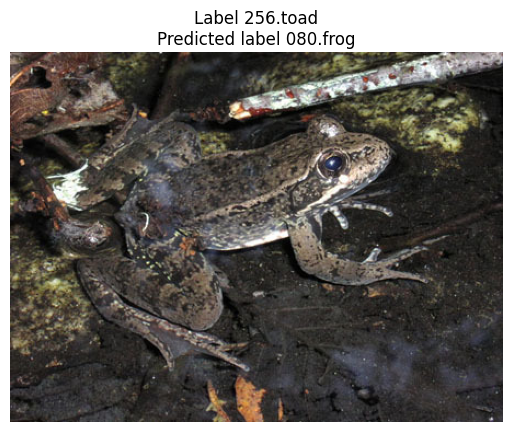

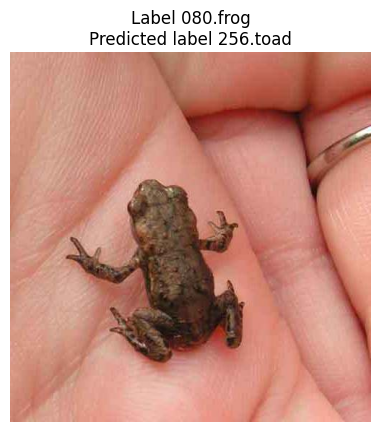

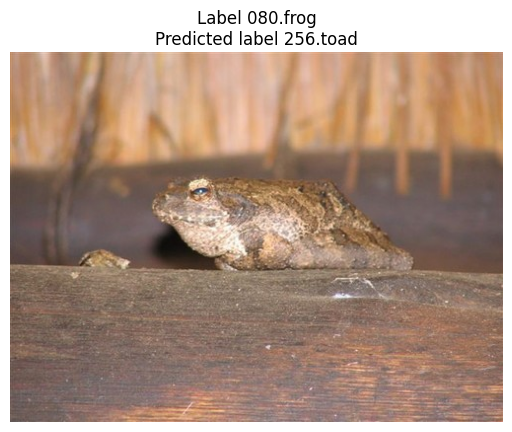

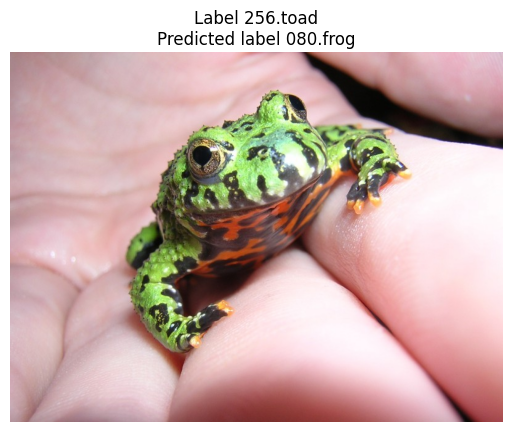

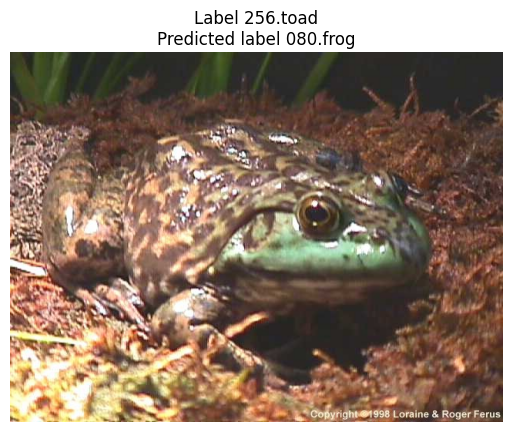

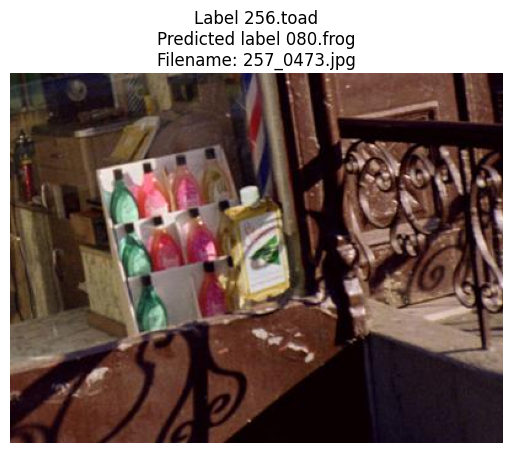

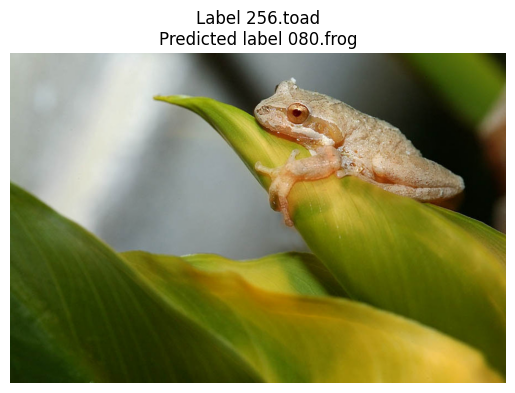

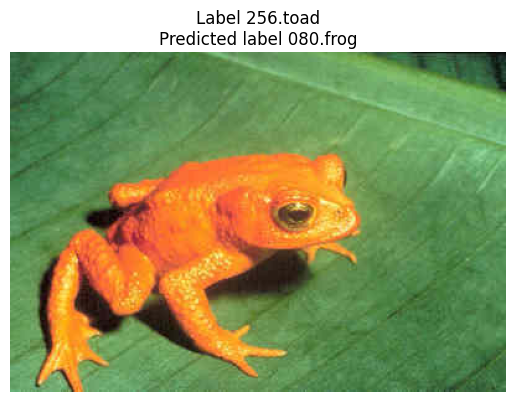

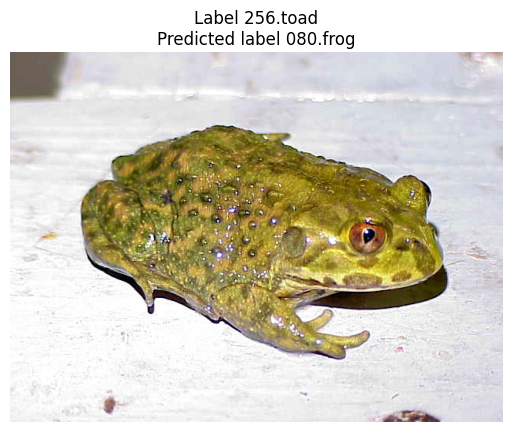

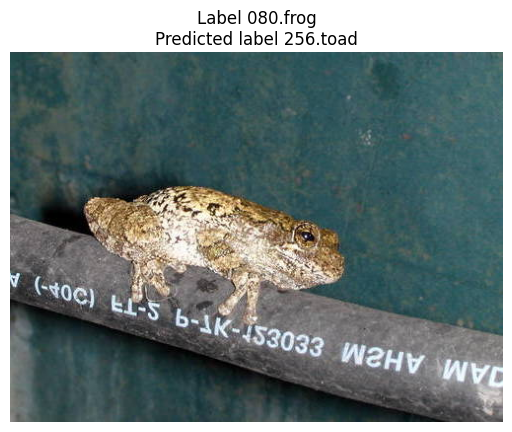

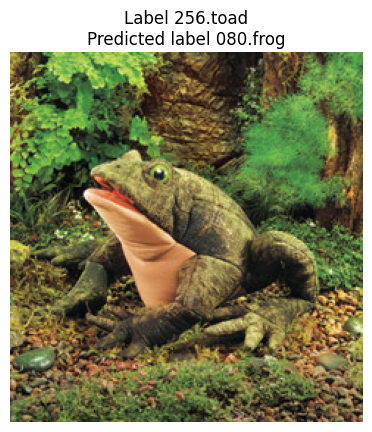

In [11]:
def plot_label_issues(row):
    idx = row.name
    image = dataset_hf[idx]["image"]
    image_filename = image.filename.split("/")[-1]
    label = label_issues.loc[idx]["given_label"]
    predicted_label = label_issues.loc[idx]["predicted_label"]


    filename_label = image_filename.split("_")[0]
    ax = plt.subplot(1, 1, 1)
    additonal_info = f"Predicted label {predicted_label}"
    if label.split(".")[0] != filename_label:
        additonal_info += f"\nFilename: {image_filename}"

    make_image_plot(ax, image, label, additonal_info=additonal_info)
    plt.show()

(
    label_issues
    .query("is_label_issue")
    .sort_values("label_score", ascending=True)
    .apply(plot_label_issues, axis=1)
)
plt.show()

# Visualizing examples that are most anomalous

In this section, we focus on visualizing examples in the dataset that are potential outliers. These are examples that are significantly different from the majority of the dataset, which may affect model performance when training or evaluating on this data.

To visualize the most anomalous examples, we:

We define a `plot_outlier_issues` function to visualize the examples that are most anomalous. This function:
that takes a row from the `outlier_issues` DataFrame as input. This function:

1. Retrieves the image, given label, nearest neighbor image, and nearest neighbor label based on the row index.

2. Checks if the image has already been displayed as an outlier or as a neighbor of another outlier.

3. Creates a subplot for the original image and its nearest neighbor.

4. Uses the `make_image_plot` function to display the images with additional information about their labels and whether the neighbor is also an outlier.

Similarly to the previous sections, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers.

Then sort the filtered results by their quality score in ascending order, where examples with the lowest scores are more likely to be outliers.

The `plot_outlier_issues` function is applied to each row of the filtered and sorted results.

By visualizing these anomalous examples and their nearest neighbors, we can gain insights into the dataset's diversity and the potential challenges that these unusual examples may pose during model training and evaluation.

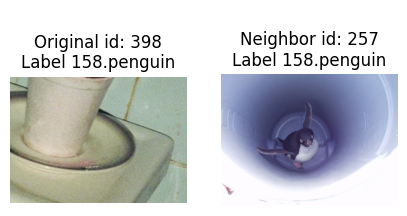

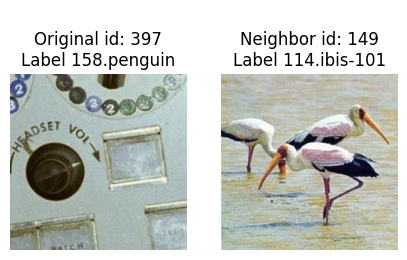

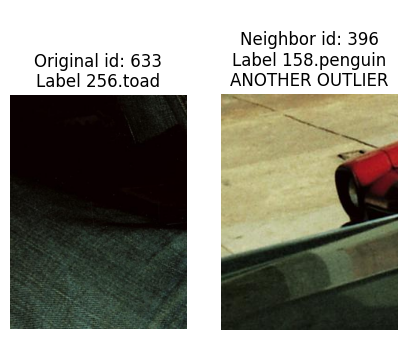

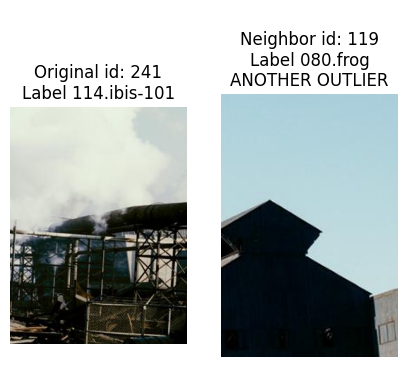

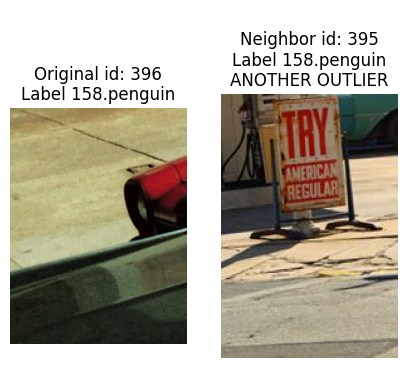

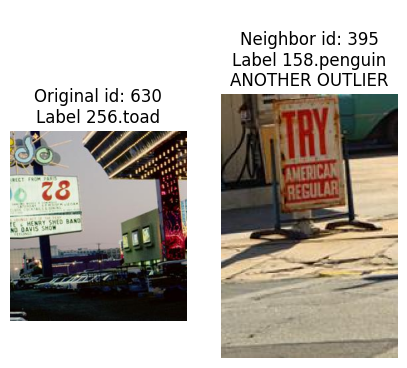

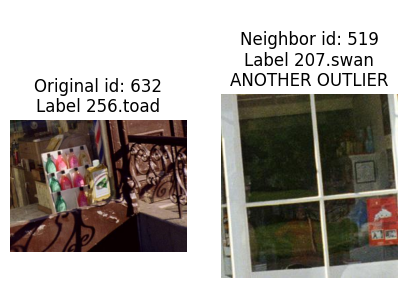

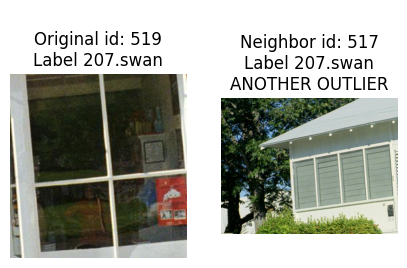

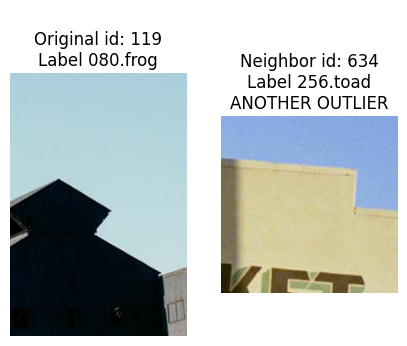

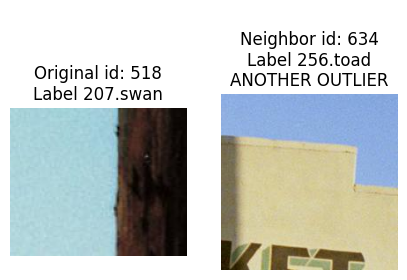

In [12]:
seen_id_pairs = set()

def plot_outlier_issues(row):
    def get_image_given_label_and_neighbor(idx):
        nearest_neighbor_idx = outlier_issues.loc[idx]["nearest_neighbor"]
        is_neighbor_outlier = outlier_issues.loc[nearest_neighbor_idx]["is_outlier_issue"]
        image, neighbor_image = (dataset_hf[int(i)]["image"] for i in (idx, nearest_neighbor_idx))
        label, neighbor_label = (label_issues.loc[i]["given_label"] for i in (idx, nearest_neighbor_idx))
        return image, neighbor_image, label, neighbor_label, nearest_neighbor_idx, is_neighbor_outlier
    
    idx = row.name

    image, neighbor_image, label, neighbor_label, nearest_neighbor_idx, is_neighbor_outlier = get_image_given_label_and_neighbor(idx)

    if (idx, nearest_neighbor_idx) in seen_id_pairs or (nearest_neighbor_idx, idx) in seen_id_pairs:
        return

    _, ax = plt.subplots(1, 2, figsize=(5, 5))


    make_image_plot(ax[0], image, additonal_info=f"Original id: {idx}\nLabel {label}")
    additional_info = f"Neighbor id: {nearest_neighbor_idx}\nLabel {neighbor_label}"
    if is_neighbor_outlier:
        additional_info += "\nANOTHER OUTLIER"
    make_image_plot(ax[1], neighbor_image, additonal_info=additional_info)
    seen_id_pairs.add((idx, nearest_neighbor_idx))
    plt.show()

(
    outlier_issues
    .query("is_outlier_issue")
    .sort_values("outlier_score", ascending=True)
    .head(10)
    .apply(plot_outlier_issues, axis=1)
)
plt.show()

# Visualizing examples with both near duplicates and inconsistent labels

In this last section, we show examples in the dataset that have both near duplicates and label errors.
While the `is_label_error` column in the `label_issues` DataFrame is a more confident indicator of label errors, we use the disagreement between the given label and predicted label instead for demonstration purposes

These examples are particularly interesting because they have issues in multiple aspects and could potentially have a greater impact on model performance.

We define a `plot_label_and_near_duplicate_issues` function that shows example images that have both issues. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

2. Fetches the near duplicate images.

3. Checks if the image and its near duplicates have already been displayed. This avoids showing identical results multiple times.

4. Creates a subplot for the original image and each of its near duplicates.


All we do differently in this section is:

- Filter the *joined* `label_issues` and `near_duplicate_issues` DataFrames to find examples that have both label errors and near duplicates.
   - Note: In the provided code, we use disagreement between the given label and predicted label instead of the `is_label_issue` flag to filter examples with label errors.

Sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

The `plot_label_and_near_duplicate_issues` function is applied to each row of the joined, filtered and sorted results.

By visualizing these examples with both label errors and near duplicates, we can better understand the complex relationships between different types of issues in the dataset and their potential impact on model training and evaluation.


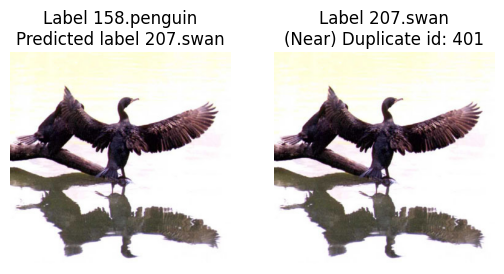

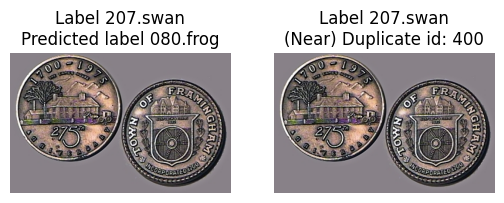

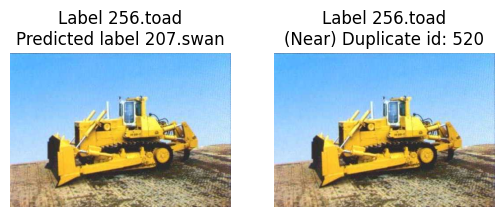

In [13]:
seen_id_pairs = set()

def plot_label_and_near_duplicate_issues(row):
    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    idx = row.name
    image, label, predicted_label= get_image_and_given_label_and_predicted_label(idx)
    duplicate_images = row.near_duplicate_sets

    id_collection = tuple(sorted([idx] + list(duplicate_images)))
    if id_collection in seen_id_pairs:
        return
    _, ax = plt.subplots(1, len(duplicate_images) + 1, figsize=((len(duplicate_images)+1.5)**2, 3))
    make_image_plot(ax[0], image, label, additonal_info=f"Predicted label {predicted_label}")
    for i, duplicate_image in enumerate(duplicate_images):

        img2, label2, predicted_label2 = get_image_and_given_label_and_predicted_label(int(duplicate_image))
        if (idx, duplicate_image) in seen_id_pairs or (duplicate_image, idx) in seen_id_pairs:
            continue
        seen_id_pairs.add((idx, duplicate_image))
        make_image_plot(ax[i + 1], img2, label2, additonal_info=f"(Near) Duplicate id: {duplicate_image}")
    seen_id_pairs.add(id_collection)


# query_expr = "is_label_issue and is_near_duplicate_issue"
query_expr = "given_label != predicted_label and is_near_duplicate_issue"  # Use disagreement instead of is_label_issue
(
    label_issues
    .join(near_duplicate_issues, how="outer")
    .query(query_expr)
    .sort_values("label_score", ascending=True)
    .head(10)
    .apply(plot_label_and_near_duplicate_issues, axis=1)
)
plt.show()